# Benchmark for Community detection

 In this Benchmark we are using the LS Heuristic to label undirected Graphs.
 We start by importing dependencies.

In [14]:
from LocalPopular import extract_labels_from_communities, time_tester, calculate_scores_CD

from LocalStable import locally_stable_clustering_with_hop_distance

from GraphFunctions import generate_graph, permute_graph_with_truth

import importlib
import PlotHelperFunctions
importlib.reload(PlotHelperFunctions)

from sklearn.metrics import rand_score

import networkx as nx

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import  Modularity


import data.jazz as jazz
import data.cora as cora

## Create Graphs

For community detection, we used four different datasets.
- **Karate club**: a 34-node benchmark dataset for community detection.
- **Jazz musicians**: collaboration network of 198 jazz musicians; nodes represent musicians, edges represent co-membership in a band.
- **Cora dataset**: a citation network of 2708 machine learning papers classified into seven classes; edges denote citation links.
- **Random-25**: an instance containing 25 disjoint Erdős–Rényi graphs (10 nodes each, with p = 0.2) as communities; inter-community edges added independently with probability 0.05.

In [15]:
# Cora Dataset
cora_graph = cora.get_graph()
cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_truth = list(cora_graph.nodes[i]['subject'] for i in range(len(cora_graph.nodes())))

# Jazz Dataset
jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_truth = None

# Karate Club Dataset
karate_graph = nx.karate_club_graph()
karate_truth = list(karate_graph.nodes[i]["club"] for i in range(34))

# Erdos Renyi Graph
erdos_renyi_graph,erdos_renyi_truth = generate_graph(10,25,0.2,0.05)


## Run the algorithms

We will now run the LS Heuristic in several modes.
We will test the three introduced domains of FEN games:

- Friend-appreciating
- Enemy averse
- Balanced

Additionally for each mode we will run three different friendship-/enemy-thresholds:

- (0.2, 0.2)
- (0.25, 0.35)
- (0.4, 0.4)

These thresholds (a fraction that will be compared to the diameter of the Graph) will be used to create the friendship- and enemy-relation between data points.


Finally we will use different initial clusterings: 

- putting each agent into a singleton cluster (LocStab-S), 
- dividing agents randomly into k clusters where k is the predicted number of clusters (LocStab-P), and 
- using the output of the Leiden algorithm (LocStab-Ld).


We also run Louvian and Leiden for comparison

If you want to run this code yourself we suggest reducing the repetitions from 8 to 1.


In [16]:
import itertools
import timeit

import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]


for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   
        
         
        
        graphs = [karate_graph,cora_graph,jazz_graph,erdos_renyi_graph]
        
        expected_clusters = [2, 7, None, 25]
        
        graph_names = [ 'Karate Club','Cora', 'Jazz','Random-25']
        graph_truths =  [karate_truth,cora_truth,jazz_truth,erdos_renyi_truth]
      
        
        𝓗 = Modularity(1.0)
        
        fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
        fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)
        
        louv_out = None
        lei_out = None
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']
        
        lp_a_b =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,always_allow_exit,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering, always_allow_exit, mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering, always_allow_exit, mode='E',pre=pre)
        
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LS (Balanced) Heuristic',\
                       'LS (Friend-Oriented) Heuristic','LS (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
        
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
            
            graph, truth = permute_graph_with_truth(graph,truth)
            graph = [graph]
            truth = [truth]    
                
            agents = []
            for i in range(len(graph)):
                agents += [list(graph[i].nodes())]
    
    
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                initial_clusters = len(agents[0])
                if g_name == 'Cora':
                    a_name_modified += ' *6 starting clusters'
                    initial_clusters = 6
                
                always_allow_exit = False
                test_callable = lambda a: algo(a,initial_clusters,None,always_allow_exit)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                
                # starting with predicted number of clusters
                a_name_modified = a_name + ' starting with predicted number of clusters'
                initial_clusters = clusters
        
                always_allow_exit = False
                test_callable = lambda a: algo(a,initial_clusters,None,always_allow_exit)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
    
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                
                # start with the output of leiden
                a_name_modified = a_name + ' starting with the output of leiden'
                initial_clusters = clusters
        
                always_allow_exit = False
                test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod,always_allow_exit)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
        
                rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
    
           
    
            else:
                test_callable = lambda a : algo(a,_)
                times,outputs = time_tester(test_callable,graph)
                outputs = [extract_labels_from_communities(c.communities) for c in outputs]
        
                if algo == fn_leiden_mod:
                    lei_output = outputs
                    
                
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)

    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            values = [m[key] for m in metrics_list if isinstance(m[key], numbers.Number)]
            if values:
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                record[key] = metrics_list[0][key]  # fallback for non-numeric
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)




Quick check for the maximum standard deviation of the scores.

In [24]:
# Get standart deviations
from collections import defaultdict
import pandas as pd
import numpy as np

max_stds = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
avg_stds = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {'sum': 0.0, 'count': 0})))

for df in dfs:
    for _, row in df.iterrows():
        algo = row['Method']
        dataset = row['Dataset']
        algo_group = 'LS' if str(algo).startswith('LS') else algo  # Group LS variants

        for col in ['Rand Index', 'Modularity']:
            value = row[col]
            std = value[1] if isinstance(value, (tuple, list)) else float('nan')

            if not pd.isna(std):
                # Update max
                max_stds[algo_group][dataset][col] = max(max_stds[algo_group][dataset].get(col, float('-inf')), std)

                # Update sum and count for avg
                avg_stds[algo_group][dataset][col]['sum'] += std
                avg_stds[algo_group][dataset][col]['count'] += 1

# Final aggregation
average_stds = defaultdict(dict)
for algo_group in avg_stds:
    average_stds[algo_group] = {}
    for dataset in avg_stds[algo_group]:
        average_stds[algo_group][dataset] = {}
        for col in avg_stds[algo_group][dataset]:
            s = avg_stds[algo_group][dataset][col]
            average_stds[algo_group][dataset][col] = s['sum'] / s['count'] if s['count'] > 0 else float('nan')


print("Max Standard Deviations:")
for algo in max_stds:
    for dataset in max_stds[algo]:
        print(f"{algo} - {dataset}: ", {k: round(v, 4) for k, v in max_stds[algo][dataset].items()})

print("\nAverage Standard Deviations:")
for algo in average_stds:
    for dataset in average_stds[algo]:
        print(f"{algo} - {dataset}: ", {k: round(v, 4) for k, v in average_stds[algo][dataset].items()})


Max Standard Deviations:
Louvain (Mod) - Karate Club:  {'Rand Index': 0.0197, 'Modularity': 0.008}
Louvain (Mod) - Cora:  {'Rand Index': 0.0025, 'Modularity': 0.0022}
Louvain (Mod) - Jazz:  {'Rand Index': 0.0, 'Modularity': 0.0025}
Louvain (Mod) - Random-25:  {'Rand Index': 0.0141, 'Modularity': 0.004}
Leiden (Mod) - Karate Club:  {'Rand Index': 0.0142, 'Modularity': 0.0109}
Leiden (Mod) - Cora:  {'Rand Index': 0.002, 'Modularity': 0.0068}
Leiden (Mod) - Jazz:  {'Rand Index': 0.0, 'Modularity': 0.0031}
Leiden (Mod) - Random-25:  {'Rand Index': 0.0118, 'Modularity': 0.0049}
LS - Karate Club:  {'Rand Index': 0.1725, 'Modularity': 0.1501}
LS - Cora:  {'Rand Index': 0.0172, 'Modularity': 0.0447}
LS - Jazz:  {'Rand Index': 0.0, 'Modularity': 0.0399}
LS - Random-25:  {'Rand Index': 0.0119, 'Modularity': 0.0065}

Average Standard Deviations:
Louvain (Mod) - Karate Club:  {'Rand Index': 0.015, 'Modularity': 0.004}
Louvain (Mod) - Cora:  {'Rand Index': 0.0023, 'Modularity': 0.0019}
Louvain (Mod

## Printing Figures


Figure saved as ./figures/StableCommunity/Karate Club-Rand Index.png


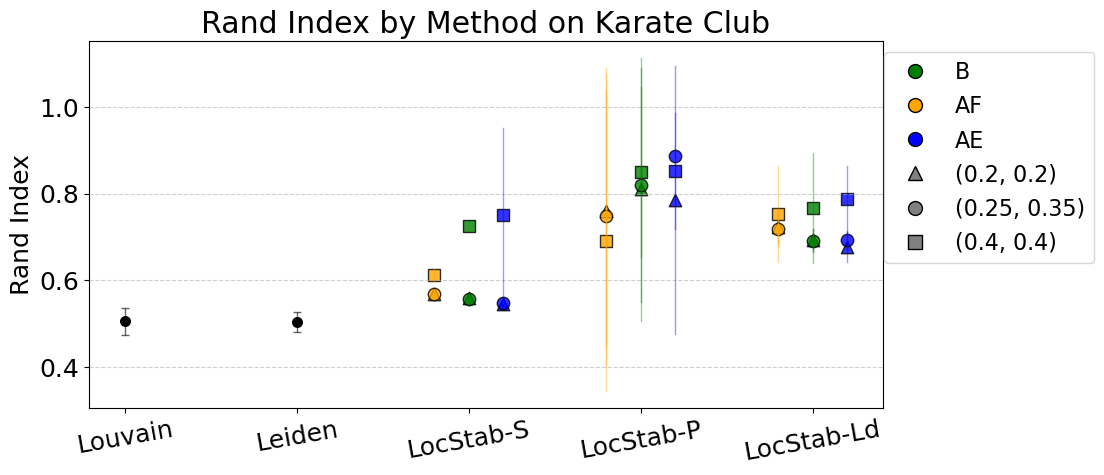

Figure saved as ./figures/StableCommunity/Karate Club-Modularity.png


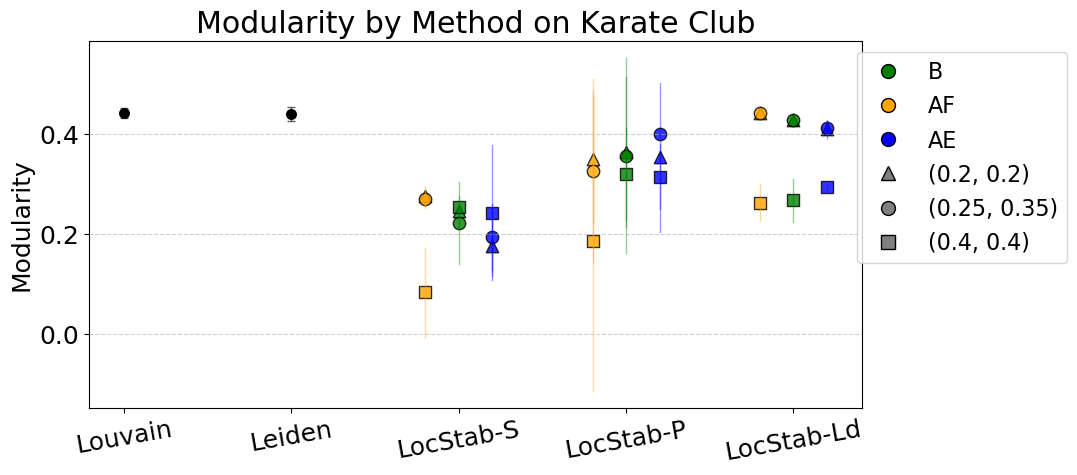

Figure saved as ./figures/StableCommunity/Cora-Rand Index.png


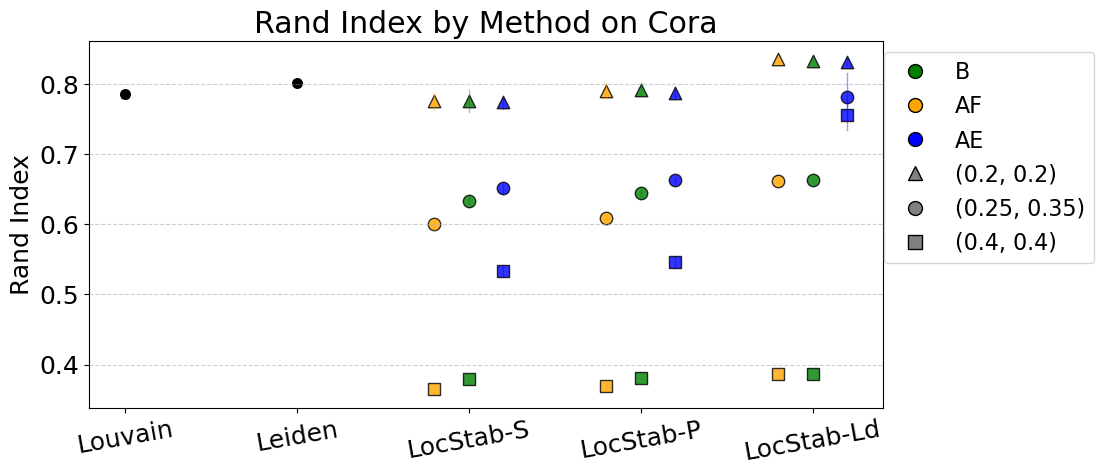

Figure saved as ./figures/StableCommunity/Cora-Modularity.png


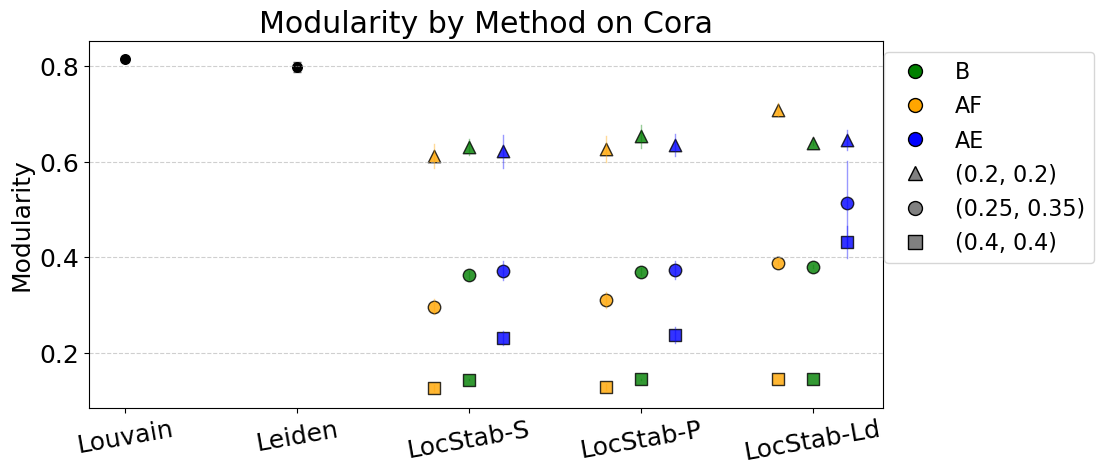

Figure saved as ./figures/StableCommunity/Random-25-Rand Index.png


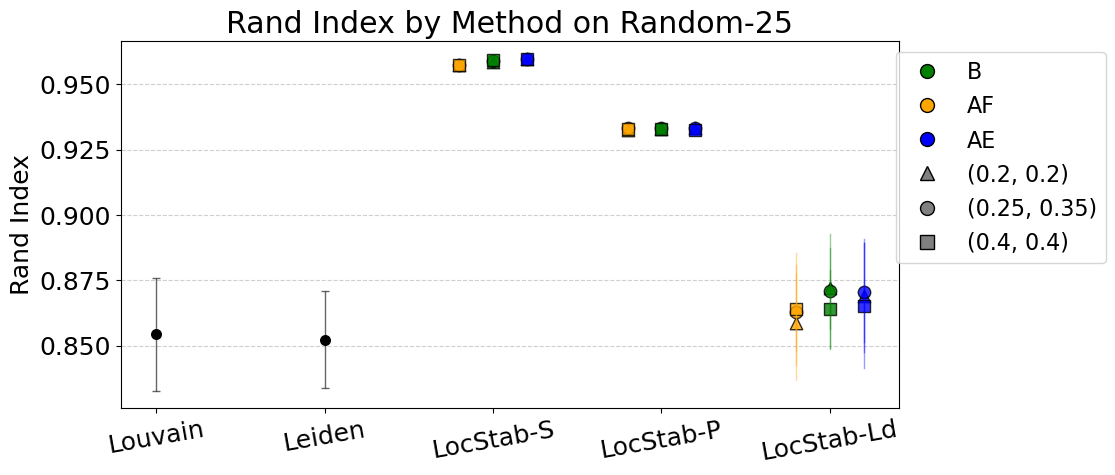

Figure saved as ./figures/StableCommunity/Random-25-Modularity.png


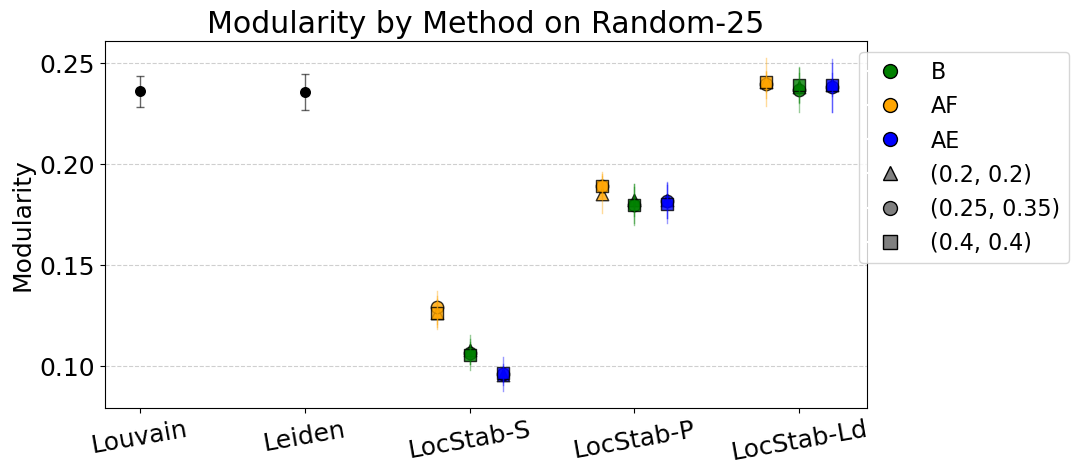

Figure saved as ./figures/StableCommunity/Jazz-Rand Index.png


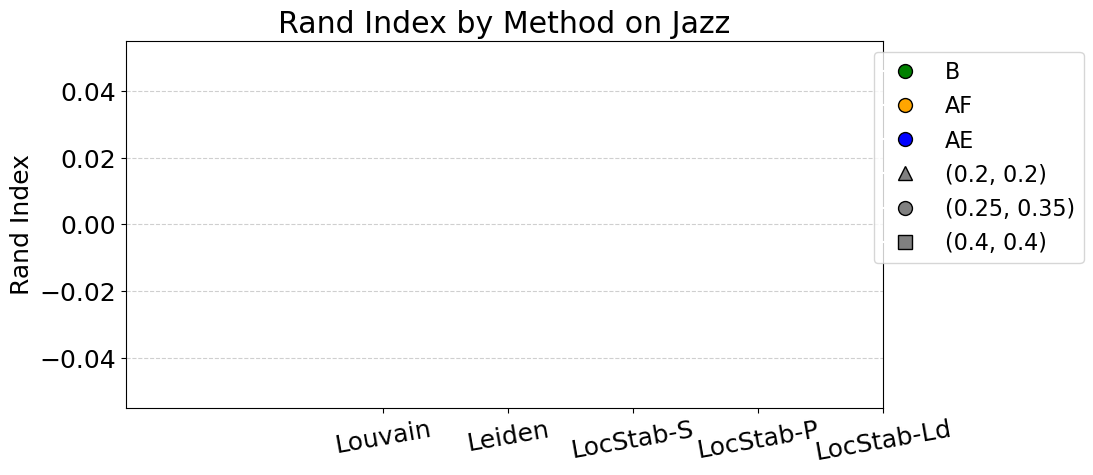

Figure saved as ./figures/StableCommunity/Jazz-Modularity.png


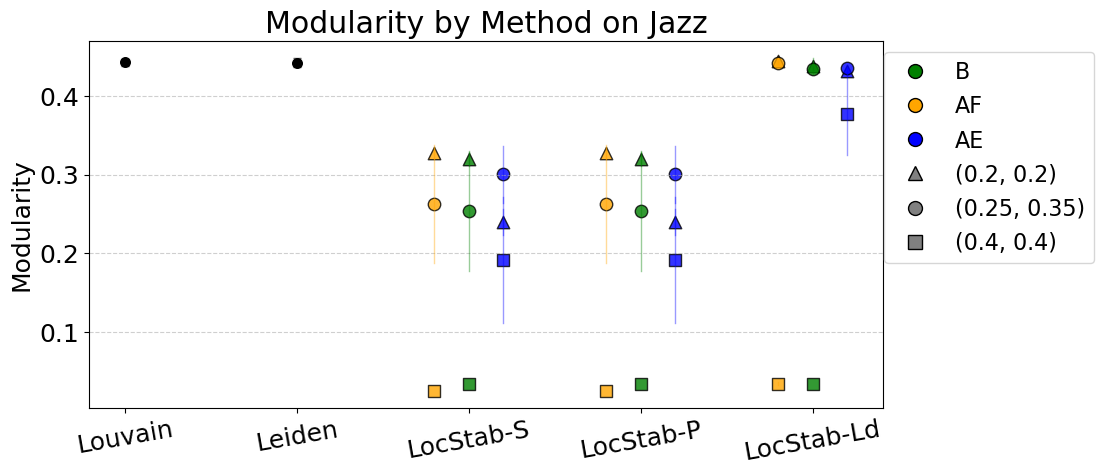

In [18]:

score_cols = ['Rand Index', 'Modularity']

labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)] 
# Plot data

for Dataset in ['Karate Club', 'Cora', 'Random-25', 'Jazz']:
    for score in score_cols:
        PlotHelperFunctions.plot_and_save_community(
            dfs, labels, Dataset, score, mode = "LS",
            save_path=f'./figures/StableCommunity/{Dataset}-{score}.png'
        )

In [19]:
import ast
import numpy as np
import pandas as pd

# Example: dfs = [df1, df2, df3]

all_values = []

for df in dfs:
    col = 'Rand Score with initial clustering'
    if col in df.columns:
        values = df[col].apply(
            lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('(')
            else x[0] if isinstance(x, (tuple, list))
            else float('nan')
        )
        all_values.extend(values.dropna().tolist())

# Convert to numpy array for convenience
all_values = np.array(all_values)

# Compute min, max, and average, ignoring NaNs
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
avg_val = np.nanmean(all_values)

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Average: {avg_val}")


Min: 0.33412922566855774
Max: 0.9490565244982783
Average: 0.668339108132994


## Saving the dataframe as csv

In [22]:
for i,df in enumerate(dfs):
    df.to_csv(f'./csv/StableCommunity/dataset-{i}.csv')